Version: 1.05

Authors: Tuan Le, Jamie Mizelle, Abdelkader Sahnoune

Date: 04/14/2024

# Introduction

The objective of this analysis is to accurately (or rather, as accurately as possible) predict if a patient who was diagnosed with diabetes and who was in the hospital for at least 14 days will be readmitted within the next 30 days following discharge. The type of machine learning used in this analysis is supervised machine learning since we are trying to predict a target variable. For the sake of simplicity, we will not list all the feature variables used in this analysis (because there are so many), but before any data preprocessing or feature engineering, there were 47 data features and one target variable (readmitted) that has three possible values (no, <30, and >30). These values correspond to whether a patient was readmitted or not or when they were readmitted if they were (the patient was not readmitted in the case of 'no', the patient was readmitted within 30 days of discharge in the case of '<30" or the patient was readmitted outside of 30 days of discharge in the case of '>30'). Success will be measured by the performance metrics of the prediction algorithms.  

# Data preprocessing and exploration 

   In this dataset, there is an almost overwhelming amount of missing values. There are several features that are missing over 40,000 values, so that had to be handled. It should be noted that only categorical data features were missing data, and all numeric data was filled correctly in this dataset. The strategy we used to handle the missing and categorical data followed what is essentially this flow pattern (notable exceptions to this general pattern are 'gender' and 'weight', which were handled slightly differently): 
 
1: If there are missing values, impute them via backfill or frontfill. 
2: OneHotEncode the categorical feature to generate dummy columns. 
 
   In the data analysis phase, we created a heatmap and pair plot of the numerical features within the dataset (and the target, that was mapped using a LabelEncoder) to see if any of the numerical features had a strong correlation to the target variable. During this phase, we found that none of the numerical features had a strong correlation to the target variable, but some of the numerical features had correlations amongst themselves (e.g., time_in_hospital and num_medication) so we gained some information in that regard. We did not do any categorical feature heatmaps or pair plots because there are quite a few of these types of features (almost 40) and many of these features contain large numbers of null values. 


In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

# Load dataset
diabetes_data_raw = fetch_ucirepo(id=296)

X = diabetes_data_raw.data.features
y = diabetes_data_raw.data.targets

# Load data from dataset for reference in code
diabetes_data = diabetes_data_raw.data

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Missing values

In [2]:
from sklearn.impute import SimpleImputer

diabetes_data_features = diabetes_data.features

#print(diabetes_data_features.describe())

print(diabetes_data_features.isnull().sum())
# There are many missing values in this dataset, it appears that there are missing values in the following columns:
# race, weight, payer_code, medical_speciality, diag_1, diag_2, diag_3, max_glu_serum, and A1Cresult.
# All of these missing values must be handled


race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

## Numeric feature exploration

In [3]:
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd
# refetch data so other code blocks aren't effected
diabetes_data_copy = fetch_ucirepo(id=296)

# Get numeric features and concat with target variable
df_init = pd.concat([diabetes_data_copy.data.features, diabetes_data_copy.data.targets], axis=1)


## Feature heatmap

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'target']
        time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                      1                  41               0                1   
1                      3                  59               0               18   
2                      2                  11               5               13   
3                      2                  44               1               16   
4                      1                  51               0                8   
...                  ...                 ...             ...              ...   
101761                 3                  51               0               16   
101762                 5                  33               3               18   
101763                 1                  53               0                9   
101764             

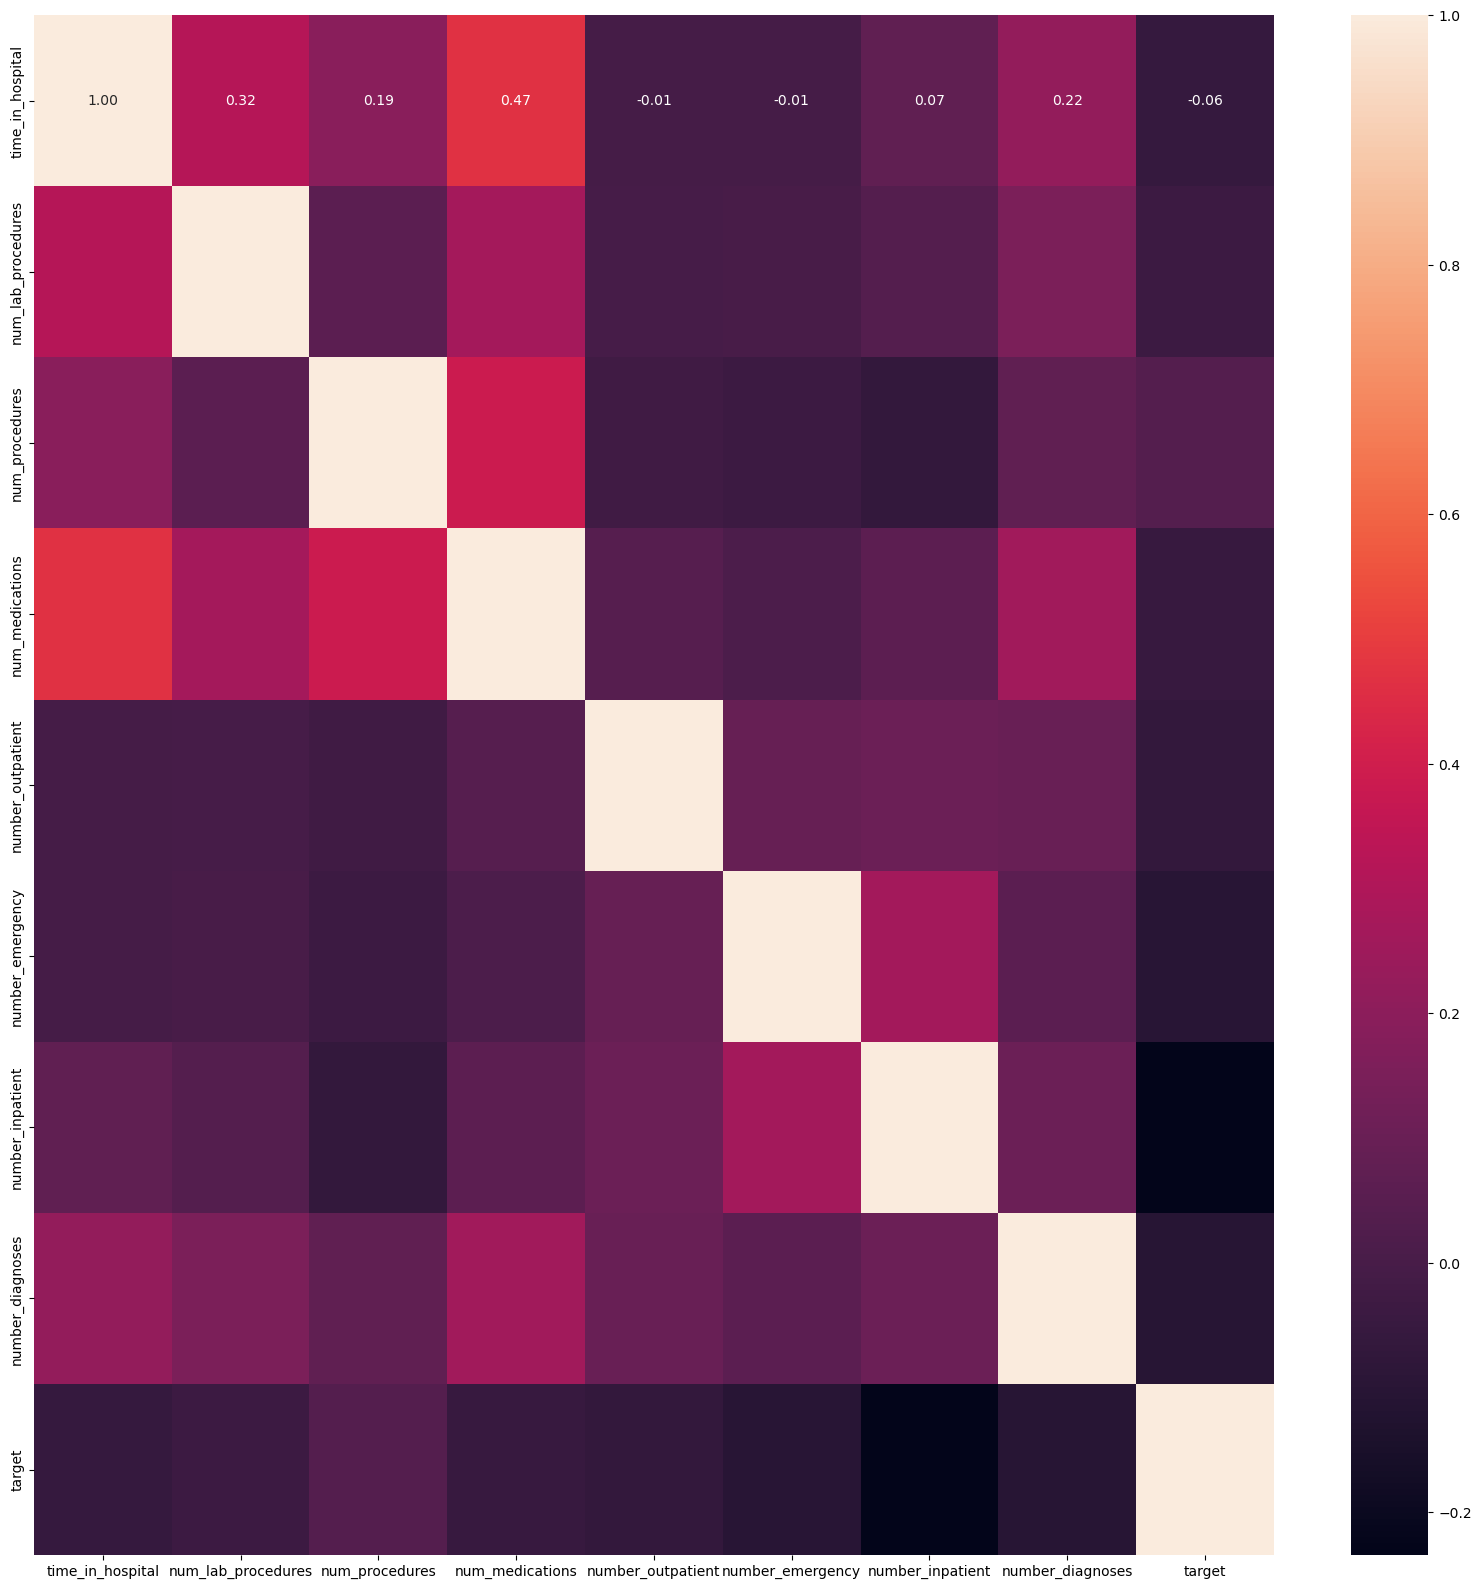

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

#print(df_init.head)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_init["readmitted"])


numeric_features = df_init.drop(columns=["readmitted"])
features_and_target = pd.concat([numeric_features, pd.Series(y_encoded, name='target')], axis=1)




numeric_cols = ["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses", "target"]
print(numeric_cols)
numeric_df = features_and_target[numeric_cols]
print(numeric_df)

corr = numeric_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()


## Feature pair plot

started


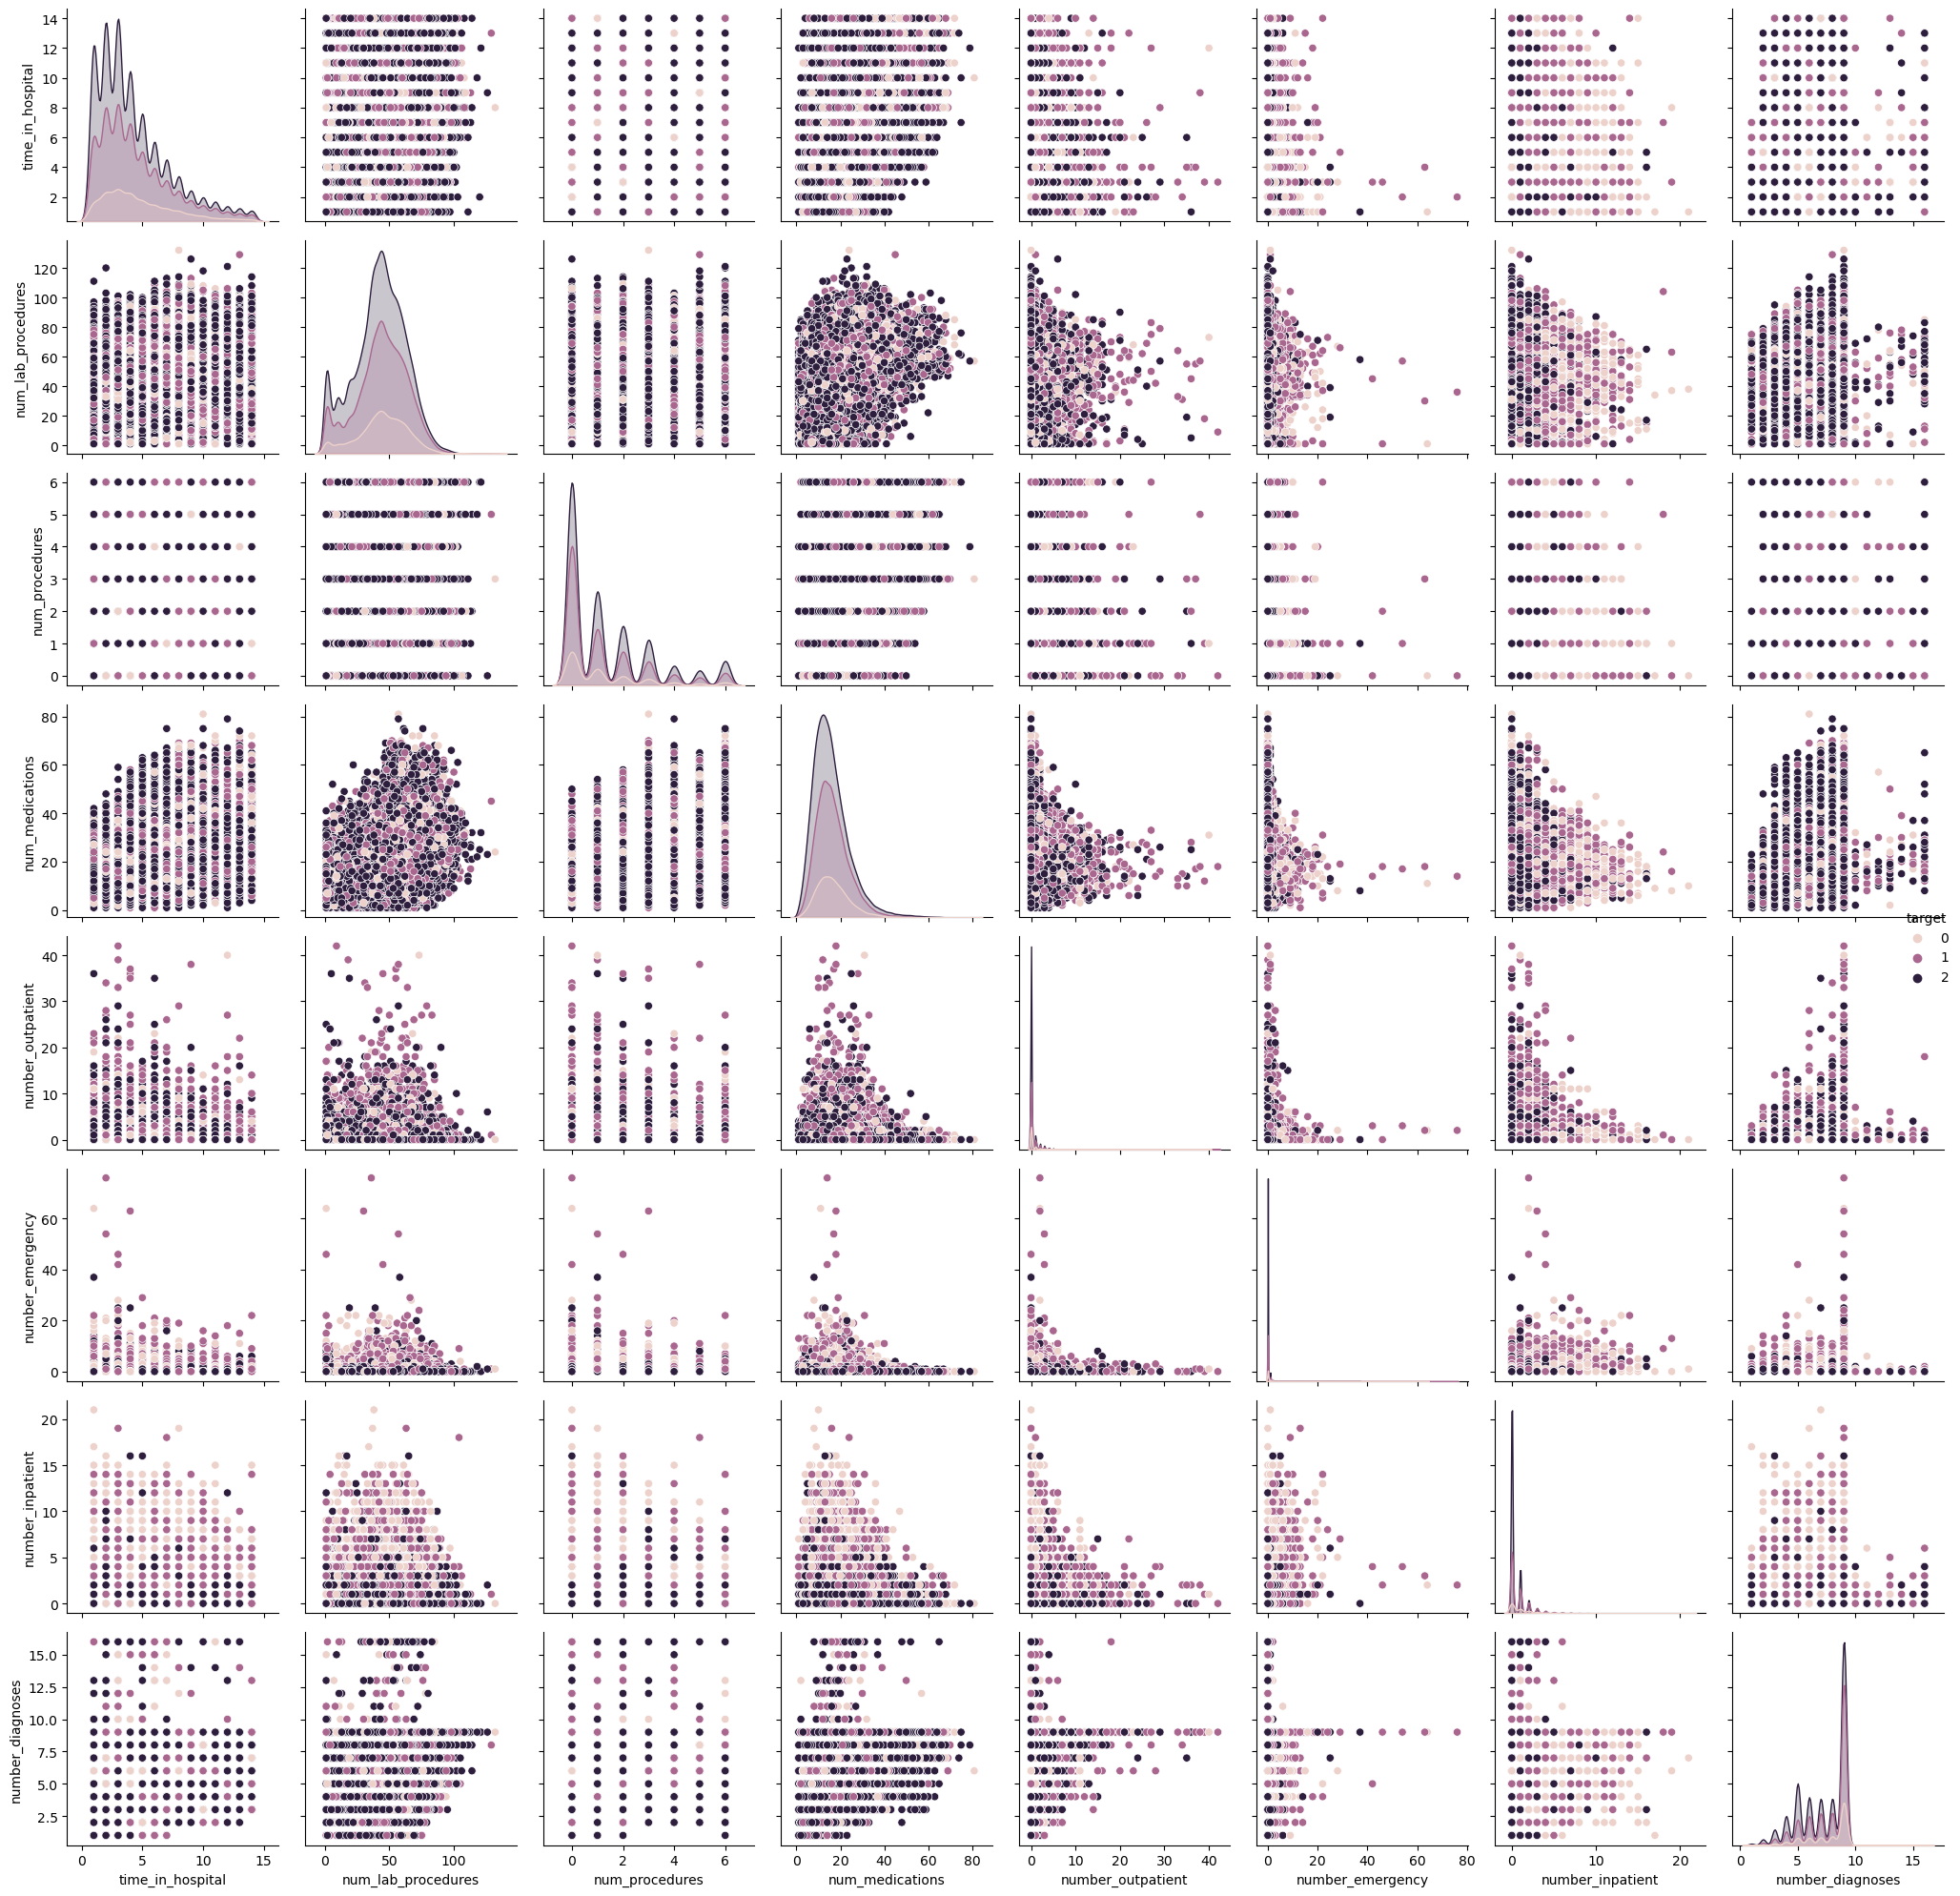

finished


In [73]:
print("started")
sns.pairplot(numeric_df, hue='target')
plt.tight_layout()
plt.show()
print("finished")

From what we can tell, none of the numeric features in this dataset have a strong correlation with the target variable (readmitted). It appears that there may be some correlation between the numerical features (such as time_in_hospital and num_medication), but other than that, we cannot gather any other important information from these graphs.

In addition, since many of the categorical features have excessive amounts of null values (in addition to there being almost 40 categorical features), we will not create any heatmaps or pair plots for the categorical features.

## Feature Engineering and Data Preprocessing

In the beginning, we chose to use six initial machine learning algorithms (RandomForestClassifier, SVC, DecisionTreeClassifier, MLPClassifier (neural network), KNN, and LogisticRegression). We evaluated the performance of these initial algorithms using the PCA training and test data with accuracy, precision, f1, and recall scores. After that, we chose the top 3 algorithms from the initial phase (RandomForestClassifier, LogisticRegression, and SVC) based on performance metrics to move into a tuning phase to find the optimal hyperparameters for each algorithm using a grid search. At this time, the best model performance we have post-tuning is LogisticRegression. However, that could change if SVC finished its tuning, unfortunately that is very unlikely because SVC takes a very long time to fit to a dataset, so even though we ran a grid search for optimal hyperparameters for over 2 days, it still never finished. The optimal hyperparameters for our best algorithm, LogisticRegression (trained with standardized data and not PCA data), are: (C=0.1, random_state=123), and the default values for the solver and penalty variables which are lbfgs and l2, respectively.

The following blocks of code will handle both feature engineering and preprocessing

### Gender feature

In [3]:
print(diabetes_data_raw.data.features['gender'].value_counts())

# Drop rows where gender is unknown (only 3 occurences)
# Drop rows from target vector first
dropRowIndices = diabetes_data_raw.data.features.loc[diabetes_data_raw.data.features['gender'] == 'Unknown/Invalid'].index
print("dropRowIndices")
print(dropRowIndices)
print("=========")

print("Features")
print(diabetes_data_raw.data.features.shape)
diabetes_data_raw.data.features.drop(dropRowIndices, inplace=True)
print(diabetes_data_raw.data.features.shape)
print("=========")

print("Target")
print(diabetes_data_raw.data.targets.shape)
diabetes_data_raw.data.targets.drop(dropRowIndices, inplace=True)
print(diabetes_data_raw.data.targets.shape)
print("=========")
                                        
print(diabetes_data_raw.data.features['gender'].value_counts())

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64
dropRowIndices
Index([30506, 75551, 82573], dtype='int64')
Features
(101766, 47)
(101763, 47)
Target
(101766, 1)
(101763, 1)
gender
Female    54708
Male      47055
Name: count, dtype: int64


### Race feature

In [4]:
print("Before impute")
print("==========")

#print(diabetes_data.targets["readmitted"].unique())
#print(diabetes_data_features["weight"].unique())
#diabetes_data_features.head(10)
#print(diabetes_data_raw.data.features.shape)
#print(diabetes_data_features["race"].describe())
print(diabetes_data_raw.data.features['race'].isnull().sum())
print(diabetes_data_raw.data.features['race'].value_counts())

# Backfill missing values in race column
race_column = diabetes_data_raw.data.features.loc[:, ["race"]]
race_column = race_column.bfill()


print("After impute")
print("==========")


diabetes_data_raw.data.features = diabetes_data_raw.data.features.drop(columns=['race'])
diabetes_data_raw.data.features = pd.concat([diabetes_data_raw.data.features, race_column], axis=1)

#print(diabetes_data_raw.data.features.shape)
#print(diabetes_data_raw.data.features['race'].describe())
print(diabetes_data_raw.data.features['race'].isnull().sum())
print(diabetes_data_raw.data.features['race'].value_counts())

# Generate dummy variables for backfilled race column
diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = ["race"], dtype=float)

print("After getDummies")
print(diabetes_data_raw.data.features.shape)

Before impute
2271
race
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1505
Asian                641
Name: count, dtype: int64
After impute
0
race
Caucasian          77817
AfricanAmerican    19670
Hispanic            2078
Other               1539
Asian                659
Name: count, dtype: int64
After getDummies
(101763, 51)


### Weight feature

In [5]:
print("Before impute")
print("==========")
# Massive number of weight values missing
print(diabetes_data_raw.data.features['weight'].isnull().sum())
print(diabetes_data_raw.data.features['weight'].value_counts())

# Impute weight based on most frequent values for each gender category
#maleWeightMode = diabetes_data_raw.data.features['weight'].mode()
#femaleWeightMode diabetes_data_raw.data.features['weight'].mode()

#mode_weight_by_gender = diabetes_data_raw.data.features.groupby(['gender','weight'])
mode_weight_by_gender = diabetes_data_raw.data.features.groupby('gender')['weight'].apply(lambda x: x.mode())


#print(mode_weight_by_gender.first())
print(mode_weight_by_gender)

# As it happens, both male and female have the same mode weight, so fill in all NaNs with [75-100) weight range.
diabetes_data_raw.data.features["weight"] = diabetes_data_raw.data.features["weight"].fillna("[75-100)")

print("After impute")
print("==========")
# Massive number of weight values imputed, could skew results
print(diabetes_data_raw.data.features['weight'].isnull().sum())
print(diabetes_data_raw.data.features['weight'].value_counts())


# Generate dummy variables for mode of weight column
diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = ["weight"], dtype=float)

# Also generate dummies for gender since we will no longer need it
diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = ["gender"], dtype=float)


print("After getDummies")
print(diabetes_data_raw.data.features.shape)



Before impute
98566
weight
[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: count, dtype: int64
gender   
Female  0    [75-100)
Male    0    [75-100)
Name: weight, dtype: object
After impute
0
weight
[75-100)     99902
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: count, dtype: int64
After getDummies
(101763, 60)


### Age feature

In [6]:
# Age is simply a categorical feature with ranges of ages.
print(diabetes_data_raw.data.features['age'].isnull().sum())
print(diabetes_data_raw.data.features['age'].value_counts())

# Since there are no missing values, we can get dummies with no other issues
diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = ["age"], dtype=float)

print("After getDummies")
print(diabetes_data_raw.data.features.shape)

0
age
[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64
After getDummies
(101763, 69)


### ID variables

In [7]:
# There are three id variables in the dataset: admission_type_id, discharge_disposition_id, and admission_source_id
print(diabetes_data_raw.data.features['admission_type_id'].isnull().sum())
print(diabetes_data_raw.data.features['discharge_disposition_id'].isnull().sum())
print(diabetes_data_raw.data.features['admission_source_id'].isnull().sum())

# Since there are no missing values, we can get dummies with no other issues
# However, since there are so many categories for these IDs (resulting in a large number of features),
# we will likely need to reduce dimensionality later on with PCA or LDA
diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = ["admission_type_id", "discharge_disposition_id", "admission_source_id"], dtype=float)

print("After getDummies")
print(diabetes_data_raw.data.features.shape)

0
0
0
After getDummies
(101763, 117)


### Payer_code feature

In [8]:
print("Before impute")
print("==========")

print(diabetes_data_raw.data.features['payer_code'].isnull().sum())
print(diabetes_data_raw.data.features['payer_code'].value_counts())

# There are quite a few missing values for this feature, for randomness sake
# we will use backfill to give the filled values a somewhat random pattern.
payer_code_column = diabetes_data_raw.data.features.loc[:, ["payer_code"]]
payer_code_column = payer_code_column.bfill()




# Place new column in feature matrix
diabetes_data_raw.data.features = diabetes_data_raw.data.features.drop(columns=['payer_code'])
diabetes_data_raw.data.features = pd.concat([diabetes_data_raw.data.features, payer_code_column], axis=1)

print("After impute")
print("==========")

print(diabetes_data_raw.data.features['payer_code'].isnull().sum())
print(diabetes_data_raw.data.features['payer_code'].value_counts())

# Get dummies for payer_code column
diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = ["payer_code"], dtype=float)

print("After getDummies")
print(diabetes_data_raw.data.features.shape)

Before impute
40255
payer_code
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2531
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64
After impute
1
payer_code
MC    64988
HM     8099
SP     6125
BC     5983
MD     4483
UN     3290
CP     3158
CM     2338
OG     1234
PO      750
DM      686
CH      184
WC      167
OT      113
MP       88
SI       75
FR        1
Name: count, dtype: int64
After getDummies
(101763, 133)


### Medical_specialty feature

In [9]:
print("Before impute")
print("==========")

print(diabetes_data_raw.data.features['medical_specialty'].isnull().sum())
print(diabetes_data_raw.data.features['medical_specialty'].value_counts())

# There are quite a few missing values for this feature, for randomness sake
# We will use backfill to give the filled values a somewhat random pattern.
medical_specialty_column = diabetes_data_raw.data.features.loc[:, ["medical_specialty"]]
medical_specialty_column = medical_specialty_column.bfill()




# Place new column in feature matrix
diabetes_data_raw.data.features = diabetes_data_raw.data.features.drop(columns=['medical_specialty'])
diabetes_data_raw.data.features = pd.concat([diabetes_data_raw.data.features, medical_specialty_column], axis=1)

print("After impute")
print("==========")

print(diabetes_data_raw.data.features['medical_specialty'].isnull().sum())
print(diabetes_data_raw.data.features['medical_specialty'].value_counts())

# Get dummies for payer_code column
diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = ["medical_specialty"], dtype=float)

print("After getDummies")
print(diabetes_data_raw.data.features.shape)

Before impute
49947
medical_specialty
InternalMedicine                    14635
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5351
Surgery-General                      3099
                                    ...  
Perinatology                            1
Neurophysiology                         1
Psychiatry-Addictive                    1
Pediatrics-InfectiousDiseases           1
Surgery-PlasticwithinHeadandNeck        1
Name: count, Length: 72, dtype: int64
After impute
1
medical_specialty
InternalMedicine                    26655
Emergency/Trauma                    18889
Family/GeneralPractice              13638
Cardiology                           9983
Surgery-General                      6398
                                    ...  
Proctology                              1
Neurophysiology                         1
Psychiatry-Addictive                    1
Pediatrics-InfectiousDiseases           1
Surgery-P

### Diag (diagnoses) features

In [10]:
# There are three diag features, diag_1 (primary diagnosis), diag_2 (secondary diagnosis), and diag_3 (additional secondary diagnosis)
print("diag_1")
print(diabetes_data_raw.data.features['diag_1'].isnull().sum())
print(diabetes_data_raw.data.features['diag_1'].value_counts())
print("====")

print("diag_2")
print(diabetes_data_raw.data.features['diag_2'].isnull().sum())
print(diabetes_data_raw.data.features['diag_2'].value_counts())
print("====")

print("diag_3")
print(diabetes_data_raw.data.features['diag_3'].isnull().sum())
print(diabetes_data_raw.data.features['diag_3'].value_counts())
print("====")

# All of these are missing some entires, backfill and get_dummies is certainly a possibility, but eventually 
# We have to make dummy features for these diagnosis, and there are over 2200 unique values in these
# columns, which means that there would be an unbelieveably high number of columns generated, so that is not a good idea.
# So instead, We will grab the top 20 (topNum) diagnosis from each column and one-hot encode those.

topNum = 20

top_diag_1 = [x for x in diabetes_data_raw.data.features['diag_1'].value_counts().sort_values(ascending=False).head(topNum).index]
print(top_diag_1)

top_diag_2 = [x for x in diabetes_data_raw.data.features['diag_2'].value_counts().sort_values(ascending=False).head(topNum).index]
print(top_diag_2)

top_diag_3 = [x for x in diabetes_data_raw.data.features['diag_3'].value_counts().sort_values(ascending=False).head(topNum).index]
print(top_diag_3)

# generate binary values for diags
for i in range(topNum):
    diag_1_label = top_diag_1[i]
    diag_2_label = top_diag_2[i]
    diag_3_label = top_diag_3[i]
    
    diabetes_data_raw.data.features['diag_1_' + diag_1_label] = np.where(diabetes_data_raw.data.features['diag_1']==diag_1_label, 1.0, 0.0)
    diabetes_data_raw.data.features['diag_2_' + diag_2_label] = np.where(diabetes_data_raw.data.features['diag_2']==diag_2_label, 1.0, 0.0)
    diabetes_data_raw.data.features['diag_3_' + diag_3_label] = np.where(diabetes_data_raw.data.features['diag_3']==diag_3_label, 1.0, 0.0)

# drop original diag columns
diabetes_data_raw.data.features = diabetes_data_raw.data.features.drop(columns=['diag_1', 'diag_2', 'diag_3'])

print("After getDummies (top 20)")
print(diabetes_data_raw.data.features.shape)

diag_1
21
diag_1
428    6862
414    6580
786    4016
410    3614
486    3508
       ... 
817       1
61        1
148       1
870       1
V51       1
Name: count, Length: 716, dtype: int64
====
diag_2
358
diag_2
276     6752
428     6662
250     6071
427     5036
401     3736
        ... 
232        1
908        1
52         1
E817       1
927        1
Name: count, Length: 748, dtype: int64
====
diag_3
1423
diag_3
250     11555
401      8288
276      5175
428      4577
427      3955
        ...  
657         1
684         1
603         1
E826        1
971         1
Name: count, Length: 789, dtype: int64
====
['428', '414', '786', '410', '486', '427', '491', '715', '682', '434', '780', '996', '276', '38', '250.8', '599', '584', 'V57', '250.6', '518']
['276', '428', '250', '427', '401', '496', '599', '403', '414', '411', '250.02', '707', '585', '584', '491', '250.01', '285', '780', '425', '682']
['250', '401', '276', '428', '427', '414', '496', '403', '585', '272', '599', 'V45', '250.02',

### Max_glu_serum feature

In [11]:
print("Before impute")
print("==========")

print(diabetes_data_raw.data.features['max_glu_serum'].isnull().sum())
print(diabetes_data_raw.data.features['max_glu_serum'].value_counts())

# There are quite a few missing values for this feature, for randomness sake
# We will use backfill and forwardfill to give the filled values a somewhat random pattern.
max_glu_serum_column = diabetes_data_raw.data.features.loc[:, ["max_glu_serum"]]
max_glu_serum_column = max_glu_serum_column.bfill()
max_glu_serum_column = max_glu_serum_column.ffill()



# Place new column in feature matrix
diabetes_data_raw.data.features = diabetes_data_raw.data.features.drop(columns=['max_glu_serum'])
diabetes_data_raw.data.features = pd.concat([diabetes_data_raw.data.features, max_glu_serum_column], axis=1)

print("After impute")
print("==========")

print(diabetes_data_raw.data.features['max_glu_serum'].isnull().sum())
print(diabetes_data_raw.data.features['max_glu_serum'].value_counts())

# Get dummies for max_glu_serum column
diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = ["max_glu_serum"], dtype=float)

print("After getDummies")
print(diabetes_data_raw.data.features.shape)

Before impute
96417
max_glu_serum
Norm    2597
>200    1485
>300    1264
Name: count, dtype: int64
After impute
0
max_glu_serum
Norm    41222
>300    36952
>200    23589
Name: count, dtype: int64
After getDummies
(101763, 263)


### A1Cresult feature

In [12]:
print("Before impute")
print("==========")

print(diabetes_data_raw.data.features['A1Cresult'].isnull().sum())
print(diabetes_data_raw.data.features['A1Cresult'].value_counts())

# There are quite a few missing values for this feature, for randomness sake
# We will use backfill and forwardfill to give the filled values a somewhat random pattern.
A1Cresult_column = diabetes_data_raw.data.features.loc[:, ["A1Cresult"]]
A1Cresult_column = A1Cresult_column.bfill()
A1Cresult_column = A1Cresult_column.ffill()



# Place new column in feature matrix
diabetes_data_raw.data.features = diabetes_data_raw.data.features.drop(columns=['A1Cresult'])
diabetes_data_raw.data.features = pd.concat([diabetes_data_raw.data.features, A1Cresult_column], axis=1)

print("After impute")
print("==========")

print(diabetes_data_raw.data.features['A1Cresult'].isnull().sum())
print(diabetes_data_raw.data.features['A1Cresult'].value_counts())

# Get dummies for A1Cresult column
diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = ["A1Cresult"], dtype=float)

print("After getDummies")
print(diabetes_data_raw.data.features.shape)

Before impute
84745
A1Cresult
>8      8216
Norm    4990
>7      3812
Name: count, dtype: int64
After impute
0
A1Cresult
>8      48916
Norm    29860
>7      22987
Name: count, dtype: int64
After getDummies
(101763, 265)


### Other drug features

In [13]:
# The remaining features of the dataset have no null values, and they are all relating to medications
# the patient may be on. Since none of them have any nulls we can get dummies for the rest of the
# categorical features. 
print("Before impute")
print("==========")

category_columns = diabetes_data_raw.data.features.select_dtypes(include='object').columns
print(category_columns)

for column in category_columns:
    diabetes_data_raw.data.features = pd.get_dummies(diabetes_data_raw.data.features, columns = [column], dtype=float)

print("After getDummies")
print(diabetes_data_raw.data.features.shape)

category_columns2 = diabetes_data_raw.data.features.select_dtypes(include='object').columns
print(category_columns2)

Before impute
Index(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')
After getDummies
(101763, 315)
Index([], dtype='object')


# Train-test split new dataset

In [14]:
# Split data into train and test sets

feature_test = diabetes_data_raw.data.features
target_test = diabetes_data_raw.data.targets


print(target_test)
print(feature_test)

X_train, X_test, y_train, y_test = train_test_split(feature_test, target_test, test_size=0.2, random_state=123, stratify=y)

print("null sums")
print(diabetes_data_raw.data.features.isnull().sum())

       readmitted
0              NO
1             >30
2              NO
3              NO
4              NO
...           ...
101761        >30
101762         NO
101763         NO
101764         NO
101765         NO

[101763 rows x 1 columns]
        time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                      1                  41               0                1   
1                      3                  59               0               18   
2                      2                  11               5               13   
3                      2                  44               1               16   
4                      1                  51               0                8   
...                  ...                 ...             ...              ...   
101761                 3                  51               0               16   
101762                 5                  33               3               18   
101763                 1    

# Feature engineering

Under different circumstances we would attempt to create derived features from the existing ones, but for this dataset there are already 315 features, so instead of trying to create more features, we will use PCA to determine which features are the most explanatory. Using 120 features (38% of the features) leads to about 55% feature explanation, so we will use 120 features in the model testing phase.

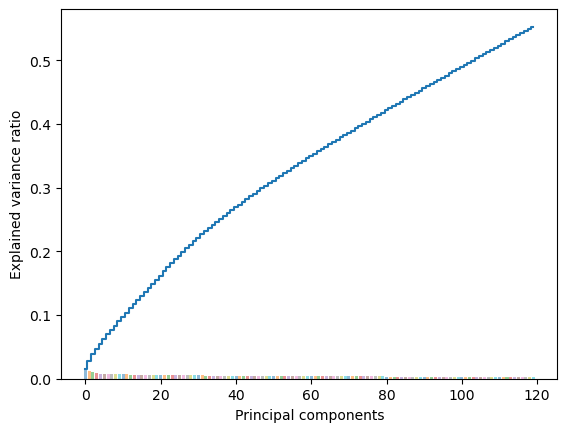

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_


total = 0
totals = []
for i in range(120):
    plt.bar(i, pca.explained_variance_ratio_[i], alpha=0.5, align='center')
    total = total + pca.explained_variance_ratio_[i]
    #print(total)
    totals.append(total)
    #plt.step(i, np.cumsum(pca.explained_variance_ratio_), where='mid')
    
plt.step(range(0, 120), totals, where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

# Set up PCA model with n_components = 120

In [16]:
pca120 = PCA(n_components=120)

X_train_pca = pca120.fit_transform(X_train_std)
X_test_pca = pca120.transform(X_test_std)

# Model training

We will use RandomForestClassifier, SVC, DecisionTreeClassifier, MLPClassifier (neural network), KNN, and LogisticRegression machine learning algorithms in our tests since these are all classification algorithms that can predict a target variable.

## Test untuned models (long to train models)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns


random_state = 123

classifierNames = ["RFC", "SVC"]
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))

               
#classifiers.append(DecisionTreeClassifier(random_state=random_state))
#classifiers.append(MLPClassifier(random_state=random_state))
#classifiers.append(KNeighborsClassifier())
#classifiers.append(LogisticRegression(random_state = random_state))

classifierNameIndex = 0
cv_results = []
for classifier in classifiers :
    classifier.fit(X_train_pca, y_train)
    y_pred = classifier.predict(X_test_pca)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')

    # output results
    print(classifierNames[classifierNameIndex])
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    classifierNameIndex = classifierNameIndex + 1



RFC
Accuracy: 0.5620301675428684
Precision: 0.5620301675428684
Recall: 0.5620301675428684
F1 Score: 0.5620301675428684


SVC
Accuracy: 0.5813393602908662
Precision: 0.5813393602908662
Recall: 0.5813393602908662
F1 Score: 0.5813393602908662


## Test untuned models (short to train models)

In [19]:
random_state = 123

classifierNames = ["DTC", "MLP (NN)", "KNN", "LR"]
classifiers = []
#classifiers.append(RandomForestClassifier(random_state=random_state))
#classifiers.append(SVC(random_state=random_state))

               
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))

classifierNameIndex = 0
cv_results = []
for classifier in classifiers :
    classifier.fit(X_train_pca, y_train)
    y_pred = classifier.predict(X_test_pca)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')

    # output results
    print(classifierNames[classifierNameIndex])
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    classifierNameIndex = classifierNameIndex + 1

DTC
Accuracy: 0.45167788532403086
Precision: 0.45167788532403086
Recall: 0.45167788532403086
F1 Score: 0.45167788532403086


MLP (NN)
Accuracy: 0.5493047707954601
Precision: 0.5493047707954601
Recall: 0.5493047707954601
F1 Score: 0.5493047707954601


KNN
Accuracy: 0.49633960595489607
Precision: 0.49633960595489607
Recall: 0.49633960595489607
F1 Score: 0.49633960595489607


LR
Accuracy: 0.5767700093352331
Precision: 0.5767700093352331
Recall: 0.5767700093352331
F1 Score: 0.5767700093352331


# Model selection

We will move to tuning (using a GridSearch) the top 3 (of the orginial 6) machine learning algorithms that had the best accuracy. These models are LR, RFC, and SVC.

## Tune short models (LR and RFC) 
took 12+ hours to complete

In [21]:
kfold = 10

lr = LogisticRegression(random_state = random_state)

LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear']
}

gsLR = GridSearchCV(lr,param_grid = LRparam_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsLR.fit(X_train_pca, y_train)


lrBest = gsLR.best_estimator_
print("LR Stats")
print("Best LR params: ", lrBest)
print("Best LR CV score: ", gsLR.best_score_)
print("")



forest = RandomForestClassifier(random_state = random_state)

RFCparam_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(forest,param_grid = RFCparam_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose = 1)
gsRFC.fit(X_train_pca, y_train)


rfcBest = gsRFC.best_estimator_
print("RFC Stats")
print("Best RFC params: ", rfcBest)
print("Best RFC CV score: ", gsRFC.best_score_)
print("")


Fitting 10 folds for each of 24 candidates, totalling 240 fits


LR Stats
Best LR params:  LogisticRegression(C=100, random_state=123)
Best LR CV score:  0.5770421324161651

Fitting 10 folds for each of 54 candidates, totalling 540 fits


RFC Stats
Best RFC params:  RandomForestClassifier(max_features=10, min_samples_leaf=3, n_estimators=300,
                       random_state=123)
Best RFC CV score:  0.5673504483478687



## Retune LogisticRegression with X_train_std instead of X_train_pca

This is done because LogisticRegression is a quickly trained algorithm whereas the other options are not, so it can hande the complexity of 315 features and still finish training in time.

In [30]:
kfold = 10

lr2 = LogisticRegression(random_state = random_state)

LRparam_grid2 = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear']
}

gsLR2 = GridSearchCV(lr,param_grid = LRparam_grid2, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsLR2.fit(X_train_std, y_train)


lrBest2 = gsLR2.best_estimator_
print("LR Stats")
print("Best LR params: ", lrBest2)
print("Best LR CV score: ", gsLR2.best_score_)
print("")

Fitting 10 folds for each of 24 candidates, totalling 240 fits


LR Stats
Best LR params:  LogisticRegression(C=0.1, random_state=123)
Best LR CV score:  0.5852229455840805



## Tune long model (SVC)

Unfortunately, we ran this code for over 2 days (around 55 hours in total!) and it never finished. SVC is still the best performing algorithm with no tuning, so if we had more time/better computing resources we may have been able to tune it, but for now we will continue with the rest of the analysis with LogisticRegression instead since it is the second best algorithm.

In [ ]:
svc = SVC(random_state=random_state)

SVCparam_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
gsSVC = GridSearchCV(svc,param_grid = SVCparam_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose = 1)
gsSVC.fit(X_train_pca, y_train)

svcBest = gsSVC.best_estimator_
print("SVC Stats")
print("Best SVC params: ", svcBest)
print("Best SVC CV score: ", gsSVC.best_score_)
print("")

Fitting 10 folds for each of 25 candidates, totalling 250 fits


# Output tuned results

In [31]:
lrNew = LogisticRegression(C=0.1, n_jobs=-1, random_state = random_state)

lrNew.fit(X_train_std, y_train)
y_pred_new = lrNew.predict(X_test_std)

accuracyNew = accuracy_score(y_test, y_pred_new)
precisionNew = precision_score(y_test, y_pred_new, average='micro')
recallNew = recall_score(y_test, y_pred_new, average='micro')
f1New = f1_score(y_test, y_pred_new, average='micro')

 # output results
print("Tuned LR")
print("Accuracy:", accuracyNew)
print("Precision:", precisionNew)
print("Recall:", recallNew)
print("F1 Score:", f1New)

Tuned LR
Accuracy: 0.5835012037537464
Precision: 0.5835012037537464
Recall: 0.5835012037537464
F1 Score: 0.5835012037537464


# Model Evaluation 
We used all four commonly used performance metrics (accuracy, precision, recall, and F1 score) on the algorithms to get as good an idea as possible of how the models perform. The best accuracy score so far is Logistic Regression (using standardized data and not PCA data), with an accuracy score of approximately 58.5%, which is unfortunately quite low, but this is quite a difficult dataset to predict. In addition, we used learning curves to see how the LR algorithm fit to the dataset, and it appears to have quite a high bias. This generally means the algorithm is underfitting in relation to the dataset, so if more time was allocated, we may try to find a fix for the lack of complexity of the LR model. 


# Code to plot learning curve to check for overfitting/underfitting

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# Generate learning curve

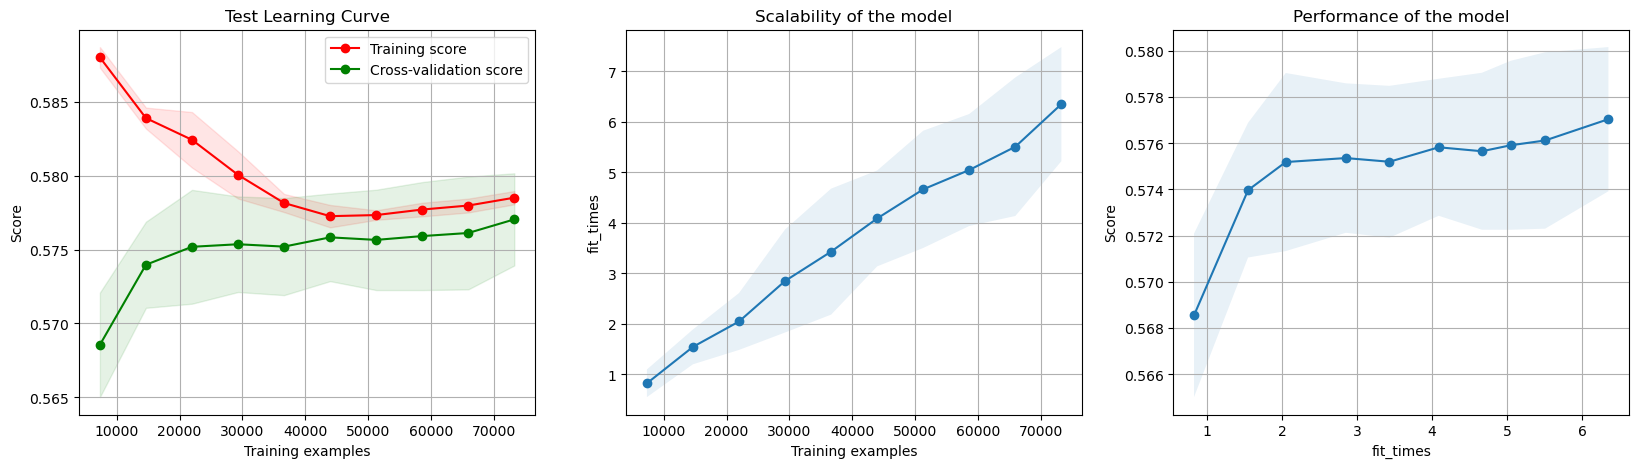

In [28]:
lrLearningCurve = LogisticRegression(C=100, n_jobs=-1, random_state = random_state)

plot_learning_curve(lrLearningCurve, 'Test Learning Curve', X_train_pca, y_train, axes=None, ylim=None, cv=10,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))

Based on the learning curves, it appears that the LogisticRegression is suffering from high bias (otherwise known as underfitting). This may be able to be fixed by increasing the number of components in the PCA or otherwise increase the models complexity.

To increase complexity, run LR learning curve with standardized data instead of PCA data

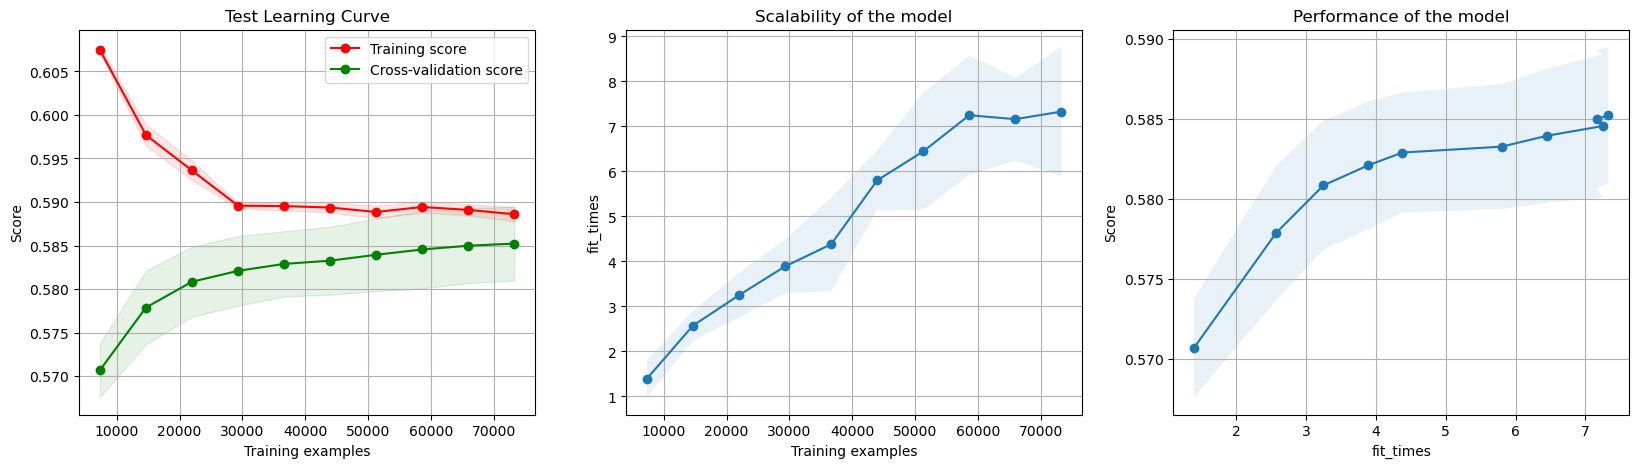

In [74]:
lrLearningCurve = LogisticRegression(C=0.1, n_jobs=-1, random_state = random_state)

plot_learning_curve(lrLearningCurve, 'Test Learning Curve', X_train_std, y_train, axes=None, ylim=None, cv=10,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))

LR running with standardized data is still underfitting and suffers from high bias, but the accuracy score for LR with standardized data is about 1% better than PCA LR, so that is our best algorithm for this classification task.

# Conclusion

In conclusion, we are able to predict if a diabetes patient is going to be readmitted or not with approximately 60% accuracy. Our best algorithm is LogisticRegression (trained with standardized data) with C=0.1. we are concerned about the high dimentionality of the dataset (315 columns), and how the data imputation was performed (since it was performed before the train-test split). In addition, we are slightly concerned about the low accuracy of the models, but we believe that is the best we could do under the circumstances. 

# Additional time

If we had more time to continue work on this project, we would probably redo the data preprocessing phase in the attempt to create a smaller dataset that still contains as much descriptive information as possible. In addition, if we had more time (and left the dataset as is) we may have been able to finish hypertuning the SVC algorithm, and if we could use standardized data with SVC, we might have gotten an accuracy score closer to (or even above) 60%. 